In [1]:
from shapely.geometry import shape, Point
import plotly.express as px
import pandas as pd
import json
import time

In [24]:
df = pd.read_csv('df-merged-v2.csv')

dfg = df[['bst_nr_8', 'num_trips', 'delay_minutes']].groupby('bst_nr_8').sum()
dfg['avg_delay'] = dfg['delay_minutes'] / dfg['num_trips']
dfg['bst_nr_8'] = dfg.index.values
dfg = dfg.reset_index(drop=True)
dfg

,num_trips,delay_minutes,avg_delay,bst_nr_8
0,7128,0,0.000000,80010561
1,7180,3137,0.436908,80010579
2,6986,0,0.000000,80010587
3,20422,221233,10.833072,80010660
4,58486,60536,1.035051,80010694
...,...,...,...,...
2825,8477,0,0.000000,80944025
2826,8360,0,0.000000,80944033
2827,762,93,0.122047,80944348
2828,1182,0,0.000000,80980961


In [9]:
df_landkreis = pd.read_csv('df-bst-landkreise-sehr-hoch.csv')
df_landkreis.head()

,bst_nr_8,name_1,name_2,name_3
0,80010561,Schleswig-Holstein,Schleswig-Holstein,Lauenburg
1,80010579,Schleswig-Holstein,Schleswig-Holstein,Lauenburg
2,80010587,Schleswig-Holstein,Schleswig-Holstein,Lauenburg
3,80010660,Hamburg,Hamburg,Hamburg Städte
4,80010694,Hamburg,Hamburg,Hamburg Städte


In [ ]:
dfg = dfg.merge(df[['bst_nr_8', 'latitude', 'longitude']].drop_duplicates(), how='left', on='bst_nr_8')
dfg

In [ ]:
dfg = dfg.rename(columns={'num_trips': 'sum_trips', 'delay_minutes': 'sum_delay_minutes'})
dfg

In [ ]:
print("Start Time: %s" % time.ctime())

# load GeoJSON file containing sectors
with open('1_sehr_hoch_bundesland.geo.json',  encoding='utf-8') as f:
    landkreise = json.load(f)

# construct point based on lon/lat returned by geocoder
# point = Point(12.071229, 51.305129)

df_result = pd.DataFrame(
        columns=['bst_nr_8', 'name_1', 'name_2', 'name_3']
)

for idx, row in dfg.iterrows():
    print('row index:', idx)
    # check each polygon to see if it contains the point
    point = Point(row['longitude'], row['latitude'])
    #
    for feature in landkreise['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            # print('Found containing polygon:', feature['properties'])
            prop = feature['properties']
            new_row = {'bst_nr_8': row['bst_nr_8'], 
                       'bundesland': prop['name'], 
                       # 'name_1': prop['NAME_1'], 
                       # 'name_2': prop['NAME_2'], 
                       # 'name_3': prop['NAME_3']
                      }
            df_result = df_result.append(new_row, ignore_index=True)
            break

print("End Time: %s" % time.ctime())

In [22]:
df_result = df_result[['bst_nr_8', 'bundesland']]
df_result = df_result.astype({"bst_nr_8": int})
df_result = df_result.reset_index(drop=True)
df_result.to_csv('df-bst-bundesland-sehr-hoch.csv', index=False)

df_result

,bst_nr_8,bundesland
0,80010561,Schleswig-Holstein
1,80010579,Schleswig-Holstein
2,80010587,Schleswig-Holstein
3,80010660,Hamburg
4,80010694,Hamburg
...,...,...
2818,80944025,Baden-Württemberg
2819,80944033,Baden-Württemberg
2820,80944348,Nordrhein-Westfalen
2821,80980961,Niedersachsen


In [25]:
# dfg = dfg.merge(df_landkreis, how='left', on='bst_nr_8')
dfg = dfg.merge(df_result, how='left', on='bst_nr_8')
dfg

,num_trips,delay_minutes,avg_delay,bst_nr_8,bundesland
0,7128,0,0.000000,80010561,Schleswig-Holstein
1,7180,3137,0.436908,80010579,Schleswig-Holstein
2,6986,0,0.000000,80010587,Schleswig-Holstein
3,20422,221233,10.833072,80010660,Hamburg
4,58486,60536,1.035051,80010694,Hamburg
...,...,...,...,...,...
2825,8477,0,0.000000,80944025,Baden-Württemberg
2826,8360,0,0.000000,80944033,Baden-Württemberg
2827,762,93,0.122047,80944348,Nordrhein-Westfalen
2828,1182,0,0.000000,80980961,Niedersachsen


In [ ]:
df = df.merge(df_result, how='left', on='bst_nr_8')
df

In [27]:
with open('4_niedrig_bundesland.geo.json',  encoding='utf-8') as f:
    landkreise = json.load(f)

fig = px.choropleth(dfg, 
                    geojson=landkreise, 
                    locations='bundesland', 
                    featureidkey="properties.name",
                    color='avg_delay',
                    scope="europe")
fig.update_geos(fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings


plt.rcParams['agg.path.chunksize'] = 1000000
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('db-cargo-delays-2016.csv', delimiter=';')
df.head()

,"BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten,dayofweek,weekofyear,month"
0,"80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3"
1,"80160168,DEUTSCHLAND,2016-01-11,12,0,1,2,1"
2,"80105122,DEUTSCHLAND,2016-04-30,16,2,6,17,4"
3,"80190793,DEUTSCHLAND,2016-07-31,14,0,7,30,7"
4,"80231464,DEUTSCHLAND,2016-04-05,10,2,2,14,4"


In [89]:
df[df['Land'] == 'DEUTSCHLAND'].head()

,BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten
0,80197079,DEUTSCHLAND,16.03.2016 00:00,39,49
1,80160168,DEUTSCHLAND,01.11.2016 00:00,12,0
2,80105122,DEUTSCHLAND,30.04.2016 00:00,16,2
3,80190793,DEUTSCHLAND,31.07.2016 00:00,14,0
4,80231464,DEUTSCHLAND,04.05.2016 00:00,10,2


In [90]:
df = df[df['Land'] == 'DEUTSCHLAND']
df = df.reset_index(drop=True)
df.to_csv('db-cargo-delays-2016-deutschland.csv', index=False)

In [91]:
len(df), len(df2), len(df) - len(df2)

(778955, 771621, 7334)

In [92]:
df['PROD_DATUM'] = pd.to_datetime(df['PROD_DATUM'])
df.head()

,BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten
0,80197079,DEUTSCHLAND,2016-03-16,39,49
1,80160168,DEUTSCHLAND,2016-01-11,12,0
2,80105122,DEUTSCHLAND,2016-04-30,16,2
3,80190793,DEUTSCHLAND,2016-07-31,14,0
4,80231464,DEUTSCHLAND,2016-04-05,10,2


In [95]:
df['dayofweek'] = df['PROD_DATUM'].dt.dayofweek + 1
df['weekofyear'] = df['PROD_DATUM'].dt.weekofyear
df['month'] = df['PROD_DATUM'].dt.month
df.head()

F:\Documents\GitProjects\hs-dl-ws-2021\autogluon\autogluon-venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten,dayofweek,weekofyear,month
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3
1,80160168,DEUTSCHLAND,2016-01-11,12,0,1,2,1
2,80105122,DEUTSCHLAND,2016-04-30,16,2,6,17,4
3,80190793,DEUTSCHLAND,2016-07-31,14,0,7,30,7
4,80231464,DEUTSCHLAND,2016-04-05,10,2,2,14,4


In [96]:
df = df.reset_index(drop=True)
df.to_csv('db-cargo-delays-2016-deutschland.csv', index=False)

In [4]:
df = pd.read_csv('db-cargo-delays-2016-deutschland.csv')
df.head()

,BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten,dayofweek,weekofyear,month
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3
1,80160168,DEUTSCHLAND,2016-01-11,12,0,1,2,1
2,80105122,DEUTSCHLAND,2016-04-30,16,2,6,17,4
3,80190793,DEUTSCHLAND,2016-07-31,14,0,7,30,7
4,80231464,DEUTSCHLAND,2016-04-05,10,2,2,14,4


In [5]:
groups = df[['Zugfahrten', 'Verspaetungsminuten', 'month']].groupby(['month'])
groups

In [6]:
groups.groups.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

No handles with labels found to put in legend.


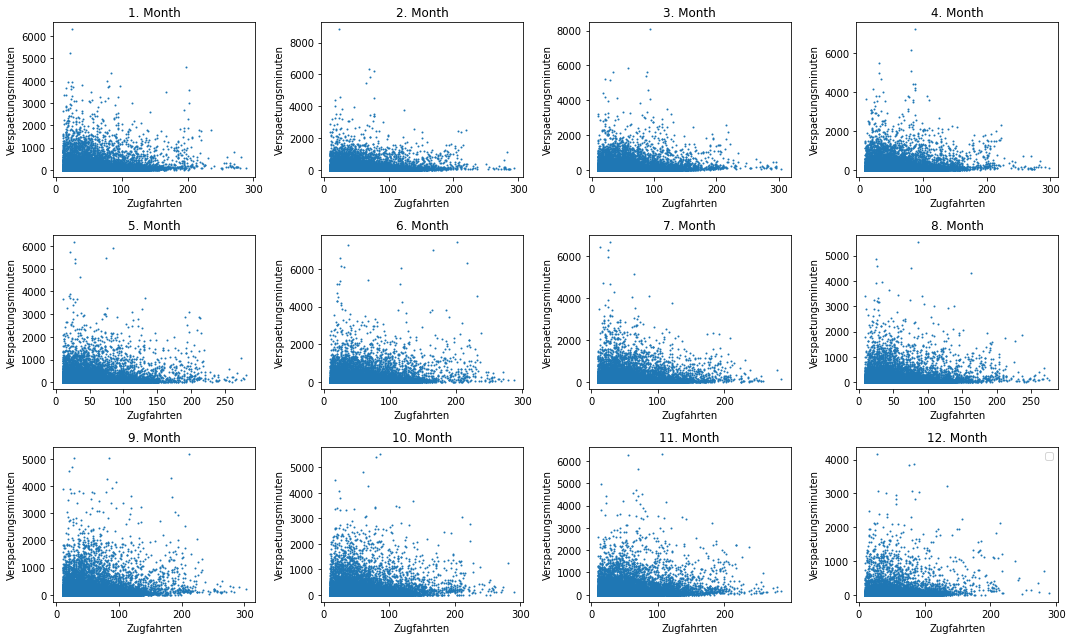

In [164]:
fig, axs = plt.subplots(3, 4, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# axs = axs.ravel()
targets = zip(groups.groups.keys(), axs.flatten())

for i, (key, ax) in enumerate(targets):
    gr = groups.get_group(i+1)
    ax.scatter(gr['Zugfahrten'], gr['Verspaetungsminuten'], s=1)
    ax.set_title('%d. Month' % key)
    ax.set_xlabel('Zugfahrten')
    ax.set_ylabel('Verspaetungsminuten')

fig.tight_layout()
ax.legend()
plt.show()

No handles with labels found to put in legend.


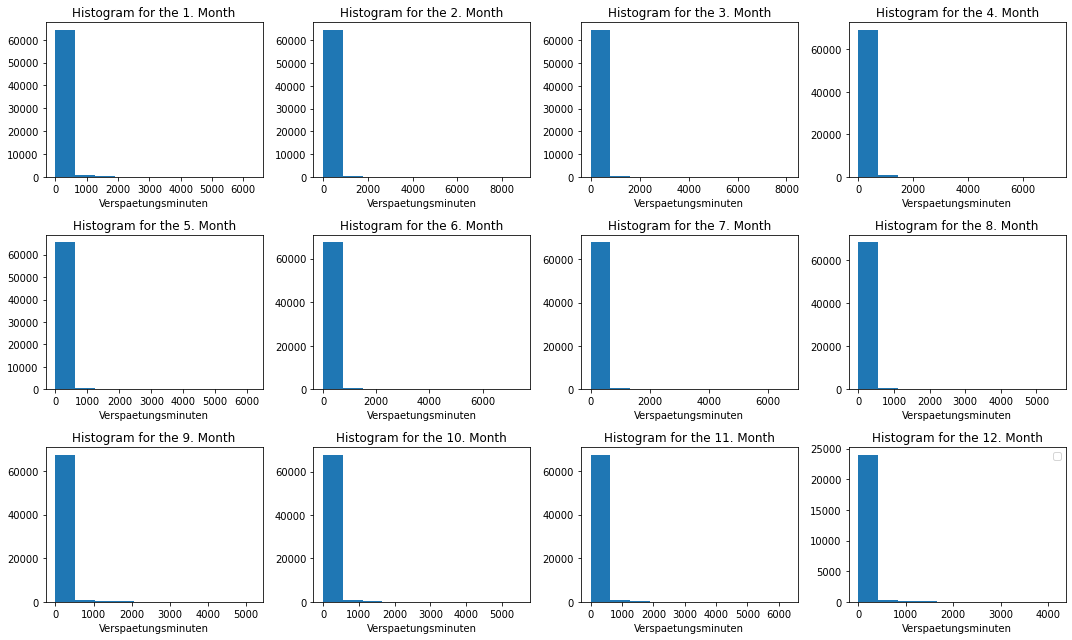

In [172]:
fig, axs = plt.subplots(3, 4, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# axs = axs.ravel()
targets = zip(groups.groups.keys(), axs.flatten())

for i, (key, ax) in enumerate(targets):
    # gr = groups.get_group(i+1)
    ax.hist(groups.get_group(i+1)['Verspaetungsminuten'])
    ax.set_title('Histogram for the %d. Month' % key)
    ax.set_xlabel('Verspaetungsminuten')
    # ax.set_ylabel('Verspaetungsminuten')

fig.tight_layout()
ax.legend()
plt.show()

<AxesSubplot:>

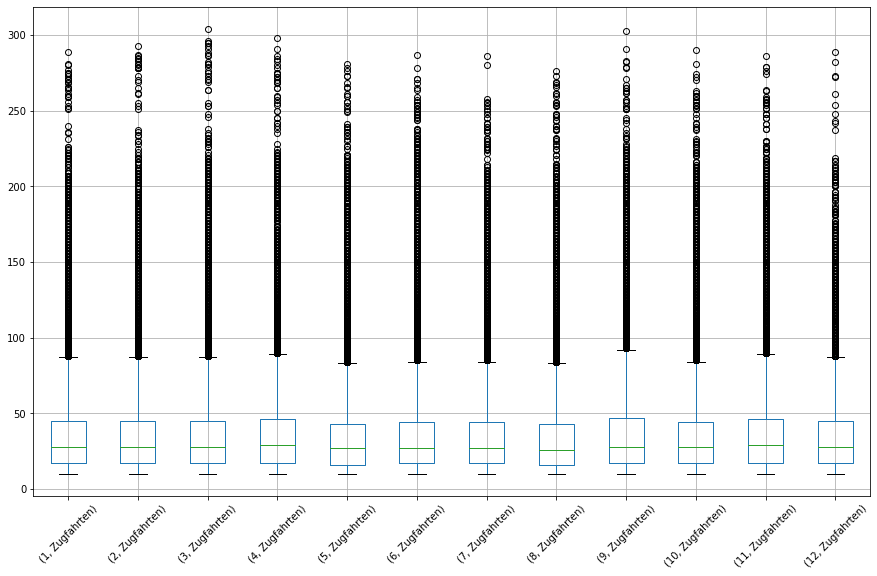

In [12]:
groups.boxplot(column='Zugfahrten', subplots=False, figsize=(15,9), rot=45)

In [3]:
df2 = pd.read_csv('db-cargo-delays-2016-deutschland.csv')
df2.head()

,BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten,dayofweek,weekofyear,month
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3
1,80160168,DEUTSCHLAND,2016-01-11,12,0,1,2,1
2,80105122,DEUTSCHLAND,2016-04-30,16,2,6,17,4
3,80190793,DEUTSCHLAND,2016-07-31,14,0,7,30,7
4,80231464,DEUTSCHLAND,2016-04-05,10,2,2,14,4


In [3]:
df = pd.read_csv('df-merged-v2.csv')
df

,bst_nr_8,country,prod_date,num_trips,delay_minutes,dayofweek,weekofyear,month,latitude,longitude,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3,49.420450,7.613668,...,5.5,1.6,9.5,0.0,0.0,49.5,21.2,NaN,1024.5,NaN
1,80197079,DEUTSCHLAND,2016-10-11,38,74,2,41,10,49.420450,7.613668,...,7.7,1.5,13.9,0.0,0.0,NaN,3.4,NaN,NaN,NaN
2,80197079,DEUTSCHLAND,2016-08-29,27,33,1,35,8,49.420450,7.613668,...,21.5,16.2,26.3,0.0,0.0,NaN,6.9,NaN,1018.8,NaN
3,80197079,DEUTSCHLAND,2016-02-25,53,85,4,8,2,49.420450,7.613668,...,2.7,-1.3,7.6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,80197079,DEUTSCHLAND,2016-05-28,39,38,6,21,5,49.420450,7.613668,...,18.0,14.1,27.1,13.8,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698163,80101972,DEUTSCHLAND,2016-07-04,12,0,1,27,7,51.538476,7.395210,...,17.2,10.7,22.4,0.0,0.0,NaN,NaN,NaN,NaN,462.0
698164,80264408,DEUTSCHLAND,2016-08-18,10,14,4,33,8,48.665453,12.598961,...,19.9,10.2,27.1,0.0,0.0,214.8,8.3,33.8,1010.2,450.0
698165,80233973,DEUTSCHLAND,2016-11-08,10,0,2,45,11,51.499080,12.421535,...,3.7,-0.4,5.8,0.5,0.0,213.0,13.3,42.5,1008.2,6.0
698166,80060517,DEUTSCHLAND,2016-09-15,14,2,4,37,9,51.013900,13.808676,...,20.4,12.1,28.6,0.0,0.0,89.2,15.8,31.0,1014.5,696.0


In [13]:
df_weather = pd.concat([pd.read_csv('weather-dat-0-100000.csv'),
                        pd.read_csv('weather-dat-100000-200000.csv'),
                        pd.read_csv('weather-dat-200000-300000.csv'),
                        pd.read_csv('weather-dat-300000-400000.csv'),
                        pd.read_csv('weather-dat-400000-500000.csv'),
                        pd.read_csv('weather-dat-500000-600000.csv'),
                        pd.read_csv('weather-dat-600000-700000.csv'),
                        pd.read_csv('weather-dat-700000-800000.csv')])
df_weather

,datetime,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,df_index
0,2016-03-16,5.5,1.6,9.5,0.0,0.0,49.5,21.2,NaN,1024.5,NaN,0
1,2016-10-11,7.7,1.5,13.9,0.0,0.0,NaN,3.4,NaN,NaN,NaN,1
2,2016-08-29,21.5,16.2,26.3,0.0,NaN,NaN,6.9,NaN,1018.8,NaN,2
3,2016-02-25,2.7,-1.3,7.6,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3
4,2016-05-28,18.0,14.1,27.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...
53599,2016-07-04,17.2,10.7,22.4,0.0,NaN,NaN,NaN,NaN,NaN,462.0,757223
53600,2016-08-18,19.9,10.2,27.1,0.0,NaN,214.8,8.3,33.8,1010.2,450.0,757224
53601,2016-11-08,3.7,-0.4,5.8,0.5,0.0,213.0,13.3,42.5,1008.2,6.0,757225
53602,2016-09-15,20.4,12.1,28.6,0.0,0.0,89.2,15.8,31.0,1014.5,696.0,757226


In [14]:
len(df_weather), len(df), len(df_weather) / len(df)

(698168, 757228, 0.9220049971739027)

In [16]:
df_merged = df.merge(df_weather, left_index=True, right_on='df_index')
df_merged = df_merged.drop(columns=['year', 'datetime', 'df_index'])

df_merged= df_merged.rename(columns={'Land': 'country', 
                                     'PROD_DATUM': 'prod_date', 
                                     'Zugfahrten': 'num_trips',
                                     'Verspaetungsminuten': 'delay_minutes',
                                     'BST_NR_8': 'bst_nr_8'})
# df_merged = df_merged.astype({"BST_NR_8": str})
df_merged['snow'] = df_merged['snow'].fillna(0)

df_merged

,bst_nr_8,country,prod_date,num_trips,delay_minutes,dayofweek,weekofyear,month,latitude,longitude,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3,49.420450,7.613668,...,5.5,1.6,9.5,0.0,0.0,49.5,21.2,NaN,1024.5,NaN
1,80197079,DEUTSCHLAND,2016-10-11,38,74,2,41,10,49.420450,7.613668,...,7.7,1.5,13.9,0.0,0.0,NaN,3.4,NaN,NaN,NaN
2,80197079,DEUTSCHLAND,2016-08-29,27,33,1,35,8,49.420450,7.613668,...,21.5,16.2,26.3,0.0,0.0,NaN,6.9,NaN,1018.8,NaN
3,80197079,DEUTSCHLAND,2016-02-25,53,85,4,8,2,49.420450,7.613668,...,2.7,-1.3,7.6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,80197079,DEUTSCHLAND,2016-05-28,39,38,6,21,5,49.420450,7.613668,...,18.0,14.1,27.1,13.8,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53599,80101972,DEUTSCHLAND,2016-07-04,12,0,1,27,7,51.538476,7.395210,...,17.2,10.7,22.4,0.0,0.0,NaN,NaN,NaN,NaN,462.0
53600,80264408,DEUTSCHLAND,2016-08-18,10,14,4,33,8,48.665453,12.598961,...,19.9,10.2,27.1,0.0,0.0,214.8,8.3,33.8,1010.2,450.0
53601,80233973,DEUTSCHLAND,2016-11-08,10,0,2,45,11,51.499080,12.421535,...,3.7,-0.4,5.8,0.5,0.0,213.0,13.3,42.5,1008.2,6.0
53602,80060517,DEUTSCHLAND,2016-09-15,14,2,4,37,9,51.013900,13.808676,...,20.4,12.1,28.6,0.0,0.0,89.2,15.8,31.0,1014.5,696.0


In [17]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698168 entries, 0 to 53603
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   bst_nr_8       698168 non-null  int64  
 1   country        698168 non-null  object 
 2   prod_date      698168 non-null  object 
 3   num_trips      698168 non-null  int64  
 4   delay_minutes  698168 non-null  int64  
 5   dayofweek      698168 non-null  int64  
 6   weekofyear     698168 non-null  int64  
 7   month          698168 non-null  int64  
 8   latitude       698168 non-null  float64
 9   longitude      698168 non-null  float64
 10  day            698168 non-null  int64  
 11  tavg           678292 non-null  float64
 12  tmin           676115 non-null  float64
 13  tmax           676115 non-null  float64
 14  prcp           697395 non-null  float64
 15  snow           698168 non-null  float64
 16  wdir           520560 non-null  float64
 17  wspd           543529 non-null

In [18]:
df_merged = df_merged.reset_index(drop=True)
df_merged.to_csv('df-merged-v2.csv', index=False)

In [19]:
del df
del df_weather

df = df_merged
df

,bst_nr_8,country,prod_date,num_trips,delay_minutes,dayofweek,weekofyear,month,latitude,longitude,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3,49.420450,7.613668,...,5.5,1.6,9.5,0.0,0.0,49.5,21.2,NaN,1024.5,NaN
1,80197079,DEUTSCHLAND,2016-10-11,38,74,2,41,10,49.420450,7.613668,...,7.7,1.5,13.9,0.0,0.0,NaN,3.4,NaN,NaN,NaN
2,80197079,DEUTSCHLAND,2016-08-29,27,33,1,35,8,49.420450,7.613668,...,21.5,16.2,26.3,0.0,0.0,NaN,6.9,NaN,1018.8,NaN
3,80197079,DEUTSCHLAND,2016-02-25,53,85,4,8,2,49.420450,7.613668,...,2.7,-1.3,7.6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,80197079,DEUTSCHLAND,2016-05-28,39,38,6,21,5,49.420450,7.613668,...,18.0,14.1,27.1,13.8,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698163,80101972,DEUTSCHLAND,2016-07-04,12,0,1,27,7,51.538476,7.395210,...,17.2,10.7,22.4,0.0,0.0,NaN,NaN,NaN,NaN,462.0
698164,80264408,DEUTSCHLAND,2016-08-18,10,14,4,33,8,48.665453,12.598961,...,19.9,10.2,27.1,0.0,0.0,214.8,8.3,33.8,1010.2,450.0
698165,80233973,DEUTSCHLAND,2016-11-08,10,0,2,45,11,51.499080,12.421535,...,3.7,-0.4,5.8,0.5,0.0,213.0,13.3,42.5,1008.2,6.0
698166,80060517,DEUTSCHLAND,2016-09-15,14,2,4,37,9,51.013900,13.808676,...,20.4,12.1,28.6,0.0,0.0,89.2,15.8,31.0,1014.5,696.0


In [6]:
# 
df_landkreise = pd.read_csv('df-bst-landkreise-sehr-hoch.csv')
df_landkreise

,bst_nr_8,bundesland,regierungsbezirk,landkreis
0,80010561,Schleswig-Holstein,Schleswig-Holstein,Lauenburg
1,80010579,Schleswig-Holstein,Schleswig-Holstein,Lauenburg
2,80010587,Schleswig-Holstein,Schleswig-Holstein,Lauenburg
3,80010660,Hamburg,Hamburg,Hamburg Städte
4,80010694,Hamburg,Hamburg,Hamburg Städte
...,...,...,...,...
2808,80944025,Baden-Württemberg,Karlsruhe,Karlsruhe
2809,80944033,Baden-Württemberg,Karlsruhe,Karlsruhe
2810,80944348,Nordrhein-Westfalen,Köln,Rhein-Sieg
2811,80980961,Niedersachsen,Luneburg,Cuxhaven


In [10]:
df = df.merge(df_landkreise, how='left', on='bst_nr_8')
df = df.reset_index(drop=True)
df.to_csv('df-merged-v2.csv', index=False)
df.head()

,bst_nr_8,country,prod_date,num_trips,delay_minutes,dayofweek,weekofyear,month,latitude,longitude,...,prcp,snow,wdir,wspd,wpgt,pres,tsun,bundesland,regierungsbezirk,landkreis
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3,49.42045,7.613668,...,0.0,0.0,49.5,21.2,NaN,1024.5,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
1,80197079,DEUTSCHLAND,2016-10-11,38,74,2,41,10,49.42045,7.613668,...,0.0,0.0,NaN,3.4,NaN,NaN,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
2,80197079,DEUTSCHLAND,2016-08-29,27,33,1,35,8,49.42045,7.613668,...,0.0,0.0,NaN,6.9,NaN,1018.8,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
3,80197079,DEUTSCHLAND,2016-02-25,53,85,4,8,2,49.42045,7.613668,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
4,80197079,DEUTSCHLAND,2016-05-28,39,38,6,21,5,49.42045,7.613668,...,13.8,0.0,NaN,NaN,NaN,NaN,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern


In [11]:
df.columns

Index(['bst_nr_8', 'country', 'prod_date', 'num_trips', 'delay_minutes',
       'dayofweek', 'weekofyear', 'month', 'latitude', 'longitude', 'day',
       'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'bundesland', 'regierungsbezirk', 'landkreis'],
      dtype='object')

In [21]:
df['landkreis'].value_counts()

Hanover                  16033
Hamburg Städte           12081
Karlsruhe                12055
Cologne Städte           11059
Main-Kinzig-Kreis         9442
                         ...  
Dithmarschen                 3
Märkisch-Oderland            1
Uecker-Randow                1
Neubrandenburg Städte        1
Gera Städte                  1
Name: landkreis, Length: 317, dtype: int64

In [12]:
def create_train_test_dataset(dataset, target_column, test_size=0.2):
    """
    :param dataset: Pandas DataFrame
    :param target_column: str
    :param test_size:
    :return:
    """
    feature_names = dataset.columns.difference([TARGET])
    X = dataset[feature_names]
    y = dataset[[TARGET]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=21)
    return X_train, X_test, y_train, y_test


def run_autogluon_experiment(dataset,
                             target_column,
                             problem_type,
                             eval_metric,
                             time_limit=600):
    """

    :param dataset:
    :param target_column:
    :param problem_type:
    :param eval_metric:
    :param time_limit:
    :return:
    """
    predictor = TabularPredictor(
        label = target_column,
        problem_type = problem_type,
        eval_metric = eval_metric,
        # learner_kwargs = {
        #    'ignored_columns': ['BST_NR_8', 'Land', 'PROD_DATUM', 'dayofweek']
        # },
        # verbosity = 2
    )
    hyperparameters={'RF':{}, 'GBM':{}, 'XT':{}, 'XGB':{}}
    predictor.fit(
        train_data = dataset,
        time_limit = time_limit,
        hyperparameters = hyperparameters, 
        # presets='high_quality_fast_inference_only_refit',
    )
    return predictor

In [35]:


# Target Column name
TARGET = 'delay_minutes'
# Test data size in percent
TEST_SIZE = 0.2
# Training time limit in seconds
TIME_LIMIT = 600
PROBLEM_TYPE = 'regression'
EVAL_METRIC = 'root_mean_squared_error'

# scaler = StandardScaler()

# dfx = df[df['landkreis'] == 'Hanover']
# dfx = df[df.columns.difference(['bst_nr_8', 'prod_date', 'country', 'month', 
#                                'day', 'bundesland', 'regierungsbezirk'])]

dfx = df[['num_trips', 'latitude', 'longitude', 'bundesland', 'delay_minutes']]

# df_merged = df_merged.astype({"BST_NR_8": str})

# dfx = dfx.dropna()
# dfx[dfx.columns.difference(['delay_minutes'])] = scaler.fit_transform(dfx[dfx.columns.difference(['delay_minutes'])])


X_train, X_test, y_train, y_test = create_train_test_dataset(
    dataset = dfx, 
    target_column = TARGET
)

train_data = pd.concat([X_train, y_train], axis=1)
    
predictor = run_autogluon_experiment(dataset=train_data,
                                     target_column=TARGET,
                                     problem_type=PROBLEM_TYPE,
                                     eval_metric=EVAL_METRIC,
                                     time_limit=TIME_LIMIT)

No path specified. Models will be saved in: "AutogluonModels/ag-20220109_131517\"
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220109_131517\"
AutoGluon Version:  0.3.1
Train Data Rows:    558534
Train Data Columns: 4
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7312.8 MB
	Train Data (Original)  Memory Usage: 54.11 MB (0.7% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in o

[1000]	train_set's rmse: 133.136	valid_set's rmse: 127.281
[2000]	train_set's rmse: 131.115	valid_set's rmse: 126.428


	-126.3367	 = Validation score   (root_mean_squared_error)
	31.72s	 = Training   runtime
	0.37s	 = Validation runtime
Fitting model: RandomForest ... Training model for up to 562.5s of the 562.5s of remaining time.
	-133.4463	 = Validation score   (root_mean_squared_error)
	103.12s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: ExtraTrees ... Training model for up to 456.87s of the 456.87s of remaining time.
	-133.1733	 = Validation score   (root_mean_squared_error)
	43.19s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 411.24s of the 411.24s of remaining time.
	-130.7729	 = Validation score   (root_mean_squared_error)
	14.12s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 386.44s of remaining time.
	-126.1355	 = Validation score   (root_mean_squared_error)
	0.87s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training

In [36]:
test_data = pd.concat([X_test, y_test], axis=1)
test_performance = predictor.evaluate(test_data, auxiliary_metrics=False)
test_performance

Evaluation: root_mean_squared_error on test data: -137.2620764331137
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -137.2620764331137
}


{'root_mean_squared_error': -137.2620764331137}

In [37]:
# feature importance on training dataset
predictor.feature_importance(data=train_data)

Computing feature importance via permutation shuffling for 4 features using 1000 rows with 3 shuffle sets...
	49.45s	= Expected runtime (16.48s per shuffle set)
	20.51s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
longitude,64.349050,9.688188,0.003736,3,119.863442,8.834658
num_trips,58.163346,17.439201,0.014342,3,158.091899,-41.765207
latitude,46.890581,14.274733,0.014765,3,128.686385,-34.905224
bundesland,15.459439,2.989328,0.006118,3,32.588620,-1.669742


In [38]:
# feature importance on test dataset 
predictor.feature_importance(data=test_data)

Computing feature importance via permutation shuffling for 4 features using 1000 rows with 3 shuffle sets...
	63.93s	= Expected runtime (21.31s per shuffle set)
	23.02s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
num_trips,67.261577,19.948898,0.014046,3,181.570972,-47.047818
latitude,46.514843,24.153703,0.039666,3,184.918239,-91.888553
longitude,46.148203,24.134279,0.040167,3,184.440299,-92.143893
bundesland,13.962321,4.015346,0.013239,3,36.970697,-9.046054


In [39]:
predictions = predictor.predict(test_data)

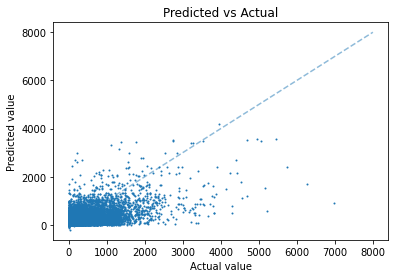

In [40]:
plt.scatter(test_data['delay_minutes'], predictions, s=1)

ident = [0.0, 8000.0]
plt.plot(ident,ident, '--', alpha=0.5)

plt.title('Predicted vs Actual')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

---------------------------------

Time limit: 10 Minutes

Dataset: db-cargo-delays-2016-deutschland.csv

Features: Zugfahrten, Verspaetungsminuten, weekofyear

RMSE: 177.84

Updated on: 06.01.2022 

---------------------------------

---------------------------------

Time limit: 10 Minutes

Dataset: df-merged-v2.csv

Features: ['bst_nr_8', 'day', 'dayofweek', 'delay_minutes', 'latitude', 'longitude', 'month', 'num_trips', 'prcp', 'pres', 'snow', 'tavg', 'tmax', 'tmin', 'tsun', 'wdir', 'weekofyear', 'wpgt', 'wspd']

Presets: 'high_quality_fast_inference_only_refit',

RMSE: 134.25

Updated on: 08.01.2022 

---------------------------------

---------------------------------

Time limit: 10 Minutes

Dataset: df-merged-v2.csv

Month: 1

Features: ['bst_nr_8', 'day', 'dayofweek', 'delay_minutes', 'latitude', 'longitude', 'month', 'num_trips', 'prcp', 'pres', 'snow', 'tavg', 'tmax', 'tmin', 'tsun', 'wdir', 'weekofyear', 'wpgt', 'wspd']

Presets: 'high_quality_fast_inference_only_refit',

RMSE: 147.47

Updated on: 08.01.2022 

---------------------------------